In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import lmfit
import ompy as om
import json

import scipy.stats as stats
import scipy.integrate as integrate
import scipy.constants as constants
import sys

#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
from ipynb.fs.full.functions import *

In [3]:
#setting figsize
plt.rcParams["figure.figsize"] = (8,6)

plt.rcParams["figure.autolayout"] = True

#size of marker and errorbar caps
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["lines.markersize"] = 5

#setting label sizes
plt.rcParams['font.size'] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 16


#set linewidths and markersize
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['lines.markersize'] = 10

#set x and y axis
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.top'] = True

plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 1.5
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['legend.frameon'] = False

#setting different dpi for notebook and saving
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.dpi"] = 80

In [4]:
om.__full_version__;
np.random.seed(1382398)

In [5]:
#gsf_values = read_OMPy('02-23_13:03:23')[0]
#gsf_values = read_OMPy('02-23_14:54:21')[0]
gsf_values = read_OMPy('02-23_14:08:46')[0]

energy_gsf_ompy = np.asarray(gsf_values[0])
gsf_ompy_median = np.asarray(gsf_values[1])
gsf_ompy_error = np.asarray(gsf_values[4])


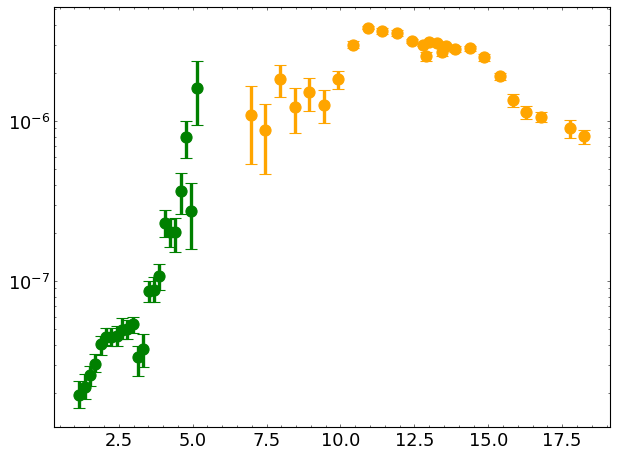

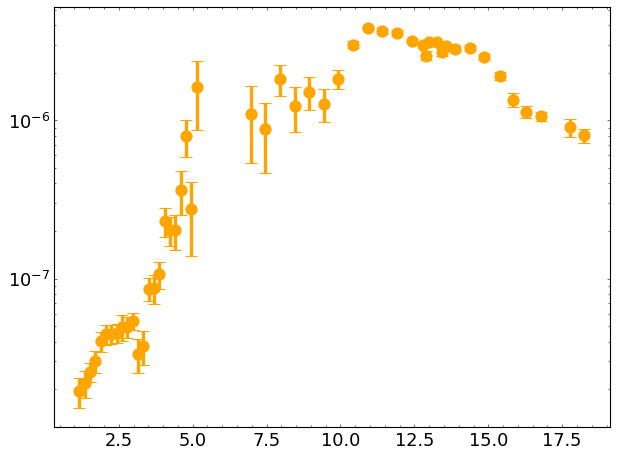

In [6]:
#with open('plotting/exfor_data/u233_g_x.json') as K:
with open('u233_g_x.json') as K:
    data_U233 = json.load(K)
datasets_U233=data_U233["datasets"]

energy_exp1, gsf_exp1, gsf_exp1_error =  extract_JSON(datasets_U233[0]['data'], 5, 0, 1)
gsf_exp1 = cs_to_gsf(energy_exp1, gsf_exp1)
gsf_exp1_error = cs_to_gsf(energy_exp1, gsf_exp1_error)

fig, ax = plt.subplots()
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='green')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')
ax.set_yscale('log')
fig.show()

#pasting all data together

#y_error_lower = np.concatenate([gsf_ompy_error[0], np.asarray(gsf_exp1_error/2)])
#y_error_upper = np.concatenate([gsf_ompy_error[1], np.asarray(gsf_exp1_error/2)])
#y_errors = [y_error_lower, y_error_upper]

#changing the errors, to one array instead of two
gsf_ompy_error_new = np.zeros(len(gsf_ompy_error[0]))
for i in range(len(gsf_ompy_error[0])):
    gsf_ompy_error_new[i] = max([gsf_ompy_error[0][i], gsf_ompy_error[1][i]])
gsf_ompy_error = gsf_ompy_error_new
y_errors = np.concatenate([gsf_ompy_error, gsf_exp1_error])


x_values = np.concatenate([energy_gsf_ompy, energy_exp1])
y_values = np.concatenate([gsf_ompy_median, gsf_exp1])

fig, ax = plt.subplots()
ax.errorbar(x=x_values, y=y_values, yerr=y_errors, fmt='o', color='orange')
ax.set_yscale('log')
fig.show()

In [7]:
#declaring fit parameters

#Define parameters & start values for the GLO
E_GLo1 = 11.4 # centroid (MeV)
Gamma_GLo1 = 2.0 # width (MeV)
sigma_GLo1 = 300 # peak cross section (mb)
E_GLo2 = 14.0 # centroid (MeV)
Gamma_GLo2 = 4.3 # width (MeV)
sigma_GLo2 = 480 # peak cross section (mb)
T_f    = 0.2 #constant temperature of final states (MeV)

#START VALUES pygmy resonance 1
E_pyg1 = 4.5 # Pygmy centroid (MeV)
Gamma_pyg1 = 0.4 # Width (MeV)
sigma_pyg1 = 5.0 #peak cross section (mb)

#START VALUES pygmy 2/spinflip resonance
E_pyg2 = 7.0 #Pygmy centroid (MeV) - this is from systematics (taken from TALYS)
Gamma_pyg2 = 1.5 #Width (MeV)
sigma_pyg2 = 20.0 #peak cross section (mb)

#START VALUES Pygmy scissors resonance
E_SR = 2.5 #Pygmy centroid (MeV) - this is from systematics (taken from TALYS)
Gamma_SR = 1.5 #Width (MeV)
sigma_SR = 1.0 #peak cross section (mb)


p0 = [T_f, E_GLo1, Gamma_GLo1, sigma_GLo1,
      E_GLo2, Gamma_GLo2, sigma_GLo2,
      E_pyg1, Gamma_pyg1, sigma_pyg1,
      E_pyg2, Gamma_pyg2, sigma_pyg2,
      E_SR, Gamma_SR, sigma_SR]
p0_functions = [GLo, GLo, SLo, SLo, SLo]
p0_functions_names = ['GLo1', 'GLo2', 'pyg1', 'pyg2', 'SR']
nuclei = "233U"

In [8]:
minimum = np.array(p0)*0.3
maximum = np.array(p0)*2.5

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_GLo1         11.47     3.42     28.5   0.1973     True     None     None
E_GLo2          14.1      4.2       35  0.07856     True     None     None
Gamma_GLo1     2.733      0.6        5   0.7798     True     None     None
Gamma_GLo2      2.87     1.29    10.75   0.7382     True     None     None
T_f              0.5     0.06      0.5   0.8306     True     None     None
sigma_GLo1       484       90      750      107     True     None     None
sigma_GLo2     301.5      144     1200    67.01     True     None     None
None


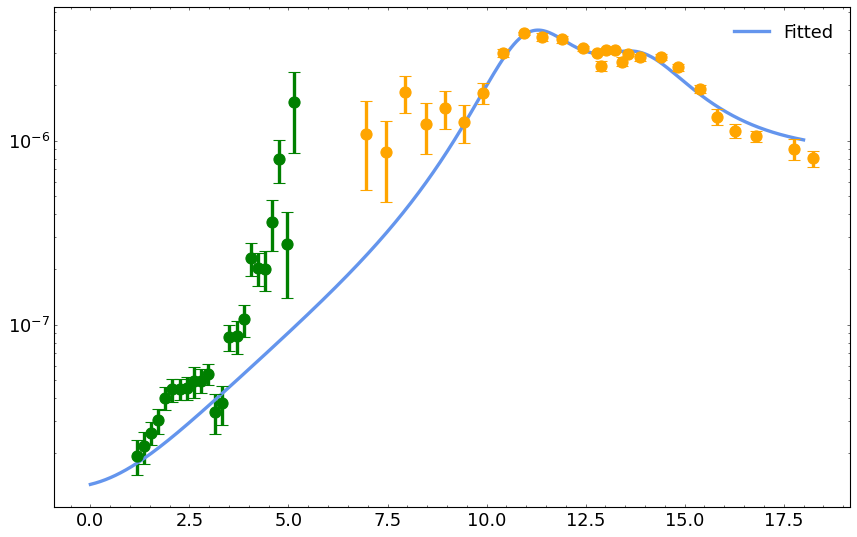

In [9]:
params_GLo = lmfit.Parameters()

#                (Name,          Value,  Weather or not to include in fit, 
#                 |              |       |     Lower fit limit, 
#                 |              |       |     |            Upper fit limit)
params_GLo.add_many(('T_f',          p0[0],  True, minimum[0],  maximum[0]),
                    ('E_GLo1',       p0[1],  True, minimum[1],  maximum[1]),
                    ('Gamma_GLo1',   p0[2],  True, minimum[2],  maximum[2]),
                    ('sigma_GLo1',   p0[3],  True, minimum[3],  maximum[3]),
                    ('E_GLo2',       p0[4],  True, minimum[4],  maximum[4]),
                    ('Gamma_GLo2',   p0[5],  True, minimum[5],  maximum[5]),
                    ('sigma_GLo2',   p0[6],  True, minimum[6],  maximum[6]),)

low_cut_GLo = 0
def f_fit_GLo(par, E = energy_exp1[low_cut_GLo:]):
    """ Marianne: make_fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2']])

    # Calculating the sum of the singular GLOs
    #to calculate the integral, i need the option of the energy to be a single point, and not an array
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
        
    for i in range(2):
        output += functions[i](E, EX[i], Gamma[i], sigma[i], T)
    return output

def f_residuals(parameters):
    return (f_fit_GLo(parameters) - gsf_exp1[low_cut_GLo:])**2/(gsf_exp1_error[low_cut_GLo:]**2)

results = lmfit.minimize(fcn=f_residuals, params=params_GLo, method="least_squares")
print(results.params.pretty_print())

plt.rcParams['text.usetex'] = False
# Initialize figure!
plt.figure(figsize=(11,7))
ax = plt.subplot(111)


# Actual best-fit curve
# Extract values from the fit
# Plot the total optimalized fit
x_values_cont = np.linspace(0, 18, 1000)
plot_fit = ax.plot(x_values_cont, f_fit_GLo(results.params, E=x_values_cont), '-', color="cornflowerblue", label="Fitted")
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='green')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')
ax.legend()
ax.set_yscale('log')

p0[0:7] = [results.params['T_f'].value, results.params['E_GLo1'].value, results.params['Gamma_GLo1'].value,
           results.params['sigma_GLo1'].value, results.params['E_GLo2'].value, results.params['Gamma_GLo2'].value,
           results.params['sigma_GLo2'].value]

[1.17 1.35 1.53 1.71 1.89 2.07 2.25 2.43 2.61 2.79 2.97 3.15 3.33 3.51
 3.69 3.87 4.05 4.23 4.41 4.59 4.77 4.95 5.13]
[1.17 1.35 1.53 1.71 1.89 2.07 2.25 2.43 2.61 2.79 2.97 3.15 3.33 3.51
 3.69 3.87 4.05 4.23 4.41 4.59 4.77 4.95 5.13]
Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_SR         2.689     0.75     6.25     None     True     None     None
Gamma_SR     2.275     0.45     3.75     None     True     None     None
T_f            0.5     0.06      0.5     None     True     None     None
sigma_SR     1.413      0.3      2.5     None     True     None     None
None
Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_SR         2.689     0.75     6.25     None     True     None     None
Gamma_SR     2.275     0.45     3.75     None     True     None     None
T_f            0.5     0.06      0.5     None     True     None     None
sigma_SR     1.413      0.3      2.5     None     True     None     None
None


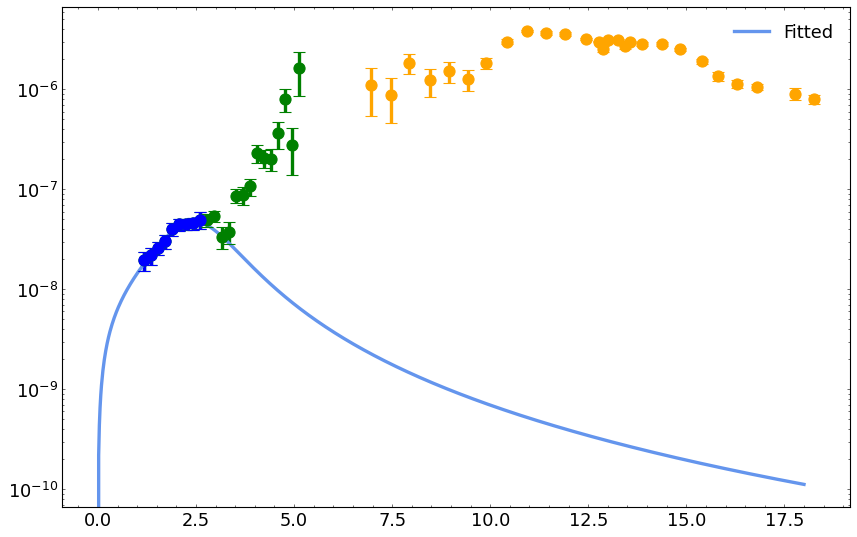

In [10]:
params_SR = lmfit.Parameters()

#                   (Name,          Value,  Weather or not to include in fit, 
#                   |               |       |     Lower fit limit, 
#                   |               |       |     |            Upper fit limit)
params_SR.add_many(('E_SR',         p0[13], True, minimum[13], maximum[13]),
                   ('Gamma_SR',     p0[14], True,  minimum[14], maximum[14]),
                   ('sigma_SR',     p0[15], True,  minimum[15], maximum[15]), 
                   ('T_f',          p0[0],  True, minimum[0],  maximum[0]))

low_cut_SR = 0
hi_cut_SR = 9

def f_fit_SR(par, E = energy_gsf_ompy[low_cut_SR:hi_cut_SR]):
    """ Marianne: make_fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par['T_f']
    EX = np.array([par['E_SR']])
    Gamma = np.array([par['Gamma_SR']])
    sigma = np.array([par['sigma_SR']])

    # Calculating the sum of the singular GLOs
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
    output += functions[4](E, EX[0], Gamma[0], sigma[0], T)
    return output

def f_residuals(parameters):
    return (f_fit_SR(parameters) - gsf_ompy_median[low_cut_SR:hi_cut_SR])**2/(gsf_ompy_error[low_cut_SR:hi_cut_SR]**2)

results = lmfit.minimize(fcn=f_residuals, params=params_SR, method="least_squares")
print(results.params.pretty_print())

plt.rcParams['text.usetex'] = False
# Initialize figure!
plt.figure(figsize=(11,7))
ax = plt.subplot(111)


# Actual best-fit curve
# Extract values from the fit
# Plot the total optimalized fit
x_values_cont = np.linspace(0, 18, 1000)
plot_fit = ax.plot(x_values_cont, f_fit_SR(results.params, E=x_values_cont), '-', color="cornflowerblue", label="Fitted")
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='green')
ax.errorbar(x=energy_gsf_ompy[low_cut_SR:hi_cut_SR], y=gsf_ompy_median[low_cut_SR:hi_cut_SR], yerr=gsf_ompy_error[low_cut_SR:hi_cut_SR], fmt='o', color='blue')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')
ax.legend()
ax.set_yscale('log')

#p0[13:16] = [results.params['E_SR'].value, results.params['Gamma_SR'].value, results.params['sigma_SR'].value]

In [11]:
minimum = np.array(p0)*1e1
maximum = np.array(p0)*1e-1
params = lmfit.Parameters()

#                (Name,          Value,  Weather or not to include in fit, 
#                 |              |       |      Lower fit limit, 
#                 |              |       |      |            Upper fit limit)
params.add_many(('T_f',          p0[0],  False, minimum[0],  maximum[0]),
                ('E_GLo1',       p0[1],  False, minimum[1],  maximum[1]),
                ('Gamma_GLo1',   p0[2],  False, minimum[2],  maximum[2]),
                ('sigma_GLo1',   p0[3],  False, minimum[3],  maximum[3]),
                ('E_GLo2',       p0[4],  False, minimum[4],  maximum[4]),
                ('Gamma_GLo2',   p0[5],  False, minimum[5],  maximum[5]),
                ('sigma_GLo2',   p0[6],  False, minimum[6],  maximum[6]),
                ('E_pyg1',       p0[7],  True,  minimum[7],  maximum[7]),
                ('Gamma_pyg1',   p0[8],  True,  minimum[8],  maximum[8]),
                ('sigma_pyg1',   p0[9],  True,  minimum[9],  maximum[9]),
                ('E_pyg2',       p0[10], True,  minimum[10], maximum[10]),
                ('Gamma_pyg2',   p0[11], True,  minimum[11], maximum[11]),
                ('sigma_pyg2',   p0[12], True,  minimum[12], maximum[12]),                
                ('E_SR',         p0[13], True,  minimum[13], maximum[13]),
                ('Gamma_SR',     p0[14], True,  minimum[14], maximum[14]),
                ('sigma_SR',     p0[15], True,  minimum[15], maximum[15]))

In [12]:
def f_fit_total(par, E = x_values):

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2'],     par['E_pyg1'],     par['E_pyg2'],     par['E_SR']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2'], par['Gamma_pyg1'], par['Gamma_pyg2'], par['Gamma_SR']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2'], par['sigma_pyg1'], par['sigma_pyg2'], par['sigma_SR']])

    # Calculating the sum of the singular GLOs
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
    for i in [0,1,2,3,4]:
        output += functions[i](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [13]:
def f_residuals(parameters):
    return (f_fit_total(parameters) - y_values)**2/(y_errors**2)

In [14]:
results = lmfit.minimize(fcn=f_residuals, params=params, method="leastsq")

print(results.params.pretty_print())
print("Chi-square of fit = %.2e"%results.chisqr)

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_GLo1         11.47    1.147    114.7        0    False     None     None
E_GLo2          14.1     1.41      141        0    False     None     None
E_SR           2.115     0.25       25   0.2541     True     None     None
E_pyg1         4.722     0.45       45   0.1005     True     None     None
E_pyg2         8.098      0.7       70   0.4129     True     None     None
Gamma_GLo1     2.733   0.2733    27.33        0    False     None     None
Gamma_GLo2      2.87    0.287     28.7        0    False     None     None
Gamma_SR      0.4267     0.15       15   0.5306     True     None     None
Gamma_pyg1    0.4216     0.04        4   0.1612     True     None     None
Gamma_pyg2    0.3445     0.15       15    1.387     True     None     None
T_f              0.5     0.05        5        0    False     None     None
sigma_GLo1       484     48.4     4840        0    False     None     None
sigma_GLo2     301.5   

0.04974555919660523
0.5488713060049557


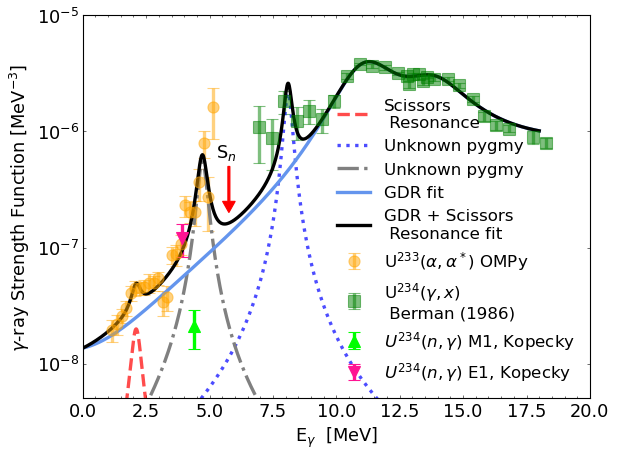

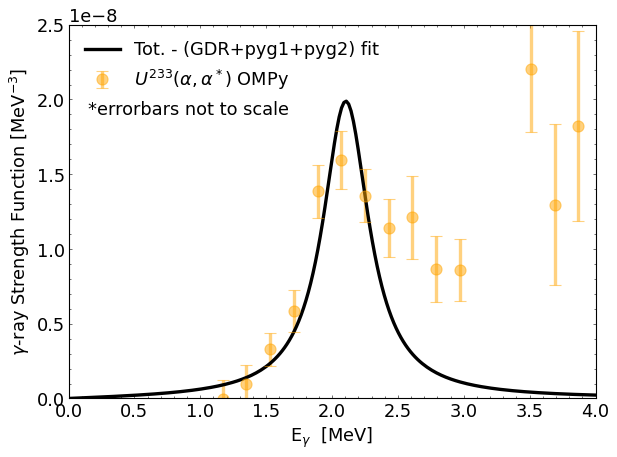

In [15]:
x_values_cont = np.linspace(0, 18, 1000)


def f_fit_plot_singular(par, E = x_values_cont, j=0):
    """ make_fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par["T_f"]
    EX = np.array([par["E_GLo1"], par["E_GLo2"], par["E_pyg1"], par["E_pyg2"], par["E_SR"]])
    Gamma = np.array([par["Gamma_GLo1"], par["Gamma_GLo2"], par["Gamma_pyg1"], par["Gamma_pyg2"], par['Gamma_SR']])
    sigma = np.array([par["sigma_GLo1"], par["sigma_GLo2"], par["sigma_pyg1"], par["sigma_pyg2"], par['sigma_SR']])

    return functions[j](E, EX[j], Gamma[j], sigma[j], T)

Sn = 5.762

plt.rcParams['text.usetex'] = False
# Initialize figure!
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

#fig = plt.figure(figsize = (12,6))
#gs = gridspec.GridSpec(1, 2, hspace=0, wspace=0.06)
#ax = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
fig, ax = plt.subplots(figsize=(8,6))

#Kopecky data
fEx = np.asarray([12.14E-08])
fEerr = np.asarray([3.92E-08])
fEene = np.asarray([3.9])
fEeneerr = np.asarray([0.00])
fMx = np.asarray([2.11E-08])
fMerr = np.asarray([0.78E-08])
fMene = np.asarray([4.4])
fMeneerr = np.asarray([0.0])



#for ax in (ax1, ax2):
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='orange', alpha=0.5, label='U$^{233}(\\alpha,\\alpha^*)$ OMPy')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='s', color='green', alpha=0.5, label="U$^{234}(\gamma,x)$\n Berman (1986)")
ax.plot(x_values_cont, f_fit_plot_singular(results.params, E=x_values_cont, j=4),'--', color="red", label='Scissors\n Resonance', alpha=0.7)
ax.plot(x_values_cont, f_fit_plot_singular(results.params, E=x_values_cont, j=3),':', color="blue", label='Unknown pygmy', alpha=0.7)
ax.plot(x_values_cont, f_fit_plot_singular(results.params, E=x_values_cont, j=2),'-.', color="gray", label='Unknown pygmy')
ax.plot(x_values_cont, f_fit_GLo(results.params, E=x_values_cont), '-', color="cornflowerblue", label="GDR fit")
ax.plot(x_values_cont, f_fit_total(results.params, E=x_values_cont), '-', color="Black", label="GDR + Scissors\n Resonance fit")



ax.errorbar(x=fMene, y=fMx, yerr=fMerr, xerr=None, fmt='^', color='lime', label="$U^{234}(n,\gamma)$ M1, Kopecky")
ax.errorbar(x=fEene, y=fEx, yerr=fEerr, xerr=None, fmt='v', color='deeppink', label="$U^{234}(n,\gamma)$ E1, Kopecky")
ax.set_yscale('log')
ax.set_xlabel('E$_\gamma$  [MeV]')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
    
ax.arrow(x=Sn, y=5e-7, dx=0, dy=-2.5e-7, width=0.08, head_width=.5, head_length=5e-8, color='r')
ax.text(Sn-.5, 6e-7, "S$_n$")    
    
    
ax.legend(fontsize=15)    
ax.set_ylim(5e-9, 1e-5)
ax.set_xlim(0, 20)
#ax2.set_ylim(1e-8, 1.5e-7)
#ax2.set_xlim(-3,5)
#ax2.set_yticks([1e-7])
ax.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')



#Find strength of scissors resonance
#extract parameters from fit
E_SR = results.params['E_SR'].value
E_SR_err = results.params['E_SR'].stderr
Gamma_SR = results.params['Gamma_SR'].value
Gamma_SR_err = results.params['Gamma_SR'].stderr
sigma_SR = results.params['sigma_SR'].value
sigma_SR_err = results.params['sigma_SR'].stderr

def SR_strength(x):
    return SLo(x, E_SR, Gamma_SR, sigma_SR, T_f)

integral = integrate.quad(SR_strength, 0,18)
hbarc = constants.physical_constants['reduced Planck constant times c in MeV fm'][0]
B_SR = integral[0] * (27/16) * hbarc**3 / constants.pi
print(B_SR)
B_SR_old = 9 * hbarc * sigma_SR * Gamma_SR / (constants.pi**2 * 32 * E_SR)
print(B_SR_old)

fig, ax = plt.subplots()
extraction = f_fit_GLo(results.params, E=x_values_cont)+f_fit_plot_singular(results.params, E=x_values_cont, j=2)+f_fit_plot_singular(results.params, E=x_values_cont, j=3)
extraction_ompy = f_fit_GLo(results.params, E=energy_gsf_ompy)+f_fit_plot_singular(results.params, E=energy_gsf_ompy, j=2)+f_fit_plot_singular(results.params, E=energy_gsf_ompy, j=3)

ax.plot(x_values_cont, f_fit_total(results.params, E=x_values_cont)-extraction,
        '-', color="Black", label="Tot. - (GDR+pyg1+pyg2) fit")
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median-extraction_ompy,
            yerr=gsf_ompy_error*0.3, 
            fmt='o', color='orange', alpha=0.5, label='$U^{233}(\\alpha,\\alpha^*)$ OMPy')
ax.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
ax.set_xlabel('E$_\gamma$  [MeV]')
ax.set_ylim(0, 2.5e-8)
ax.set_xlim(0,4)
ax.text(0.15, 1.9e-8,'*errorbars not to scale')
ax.legend();

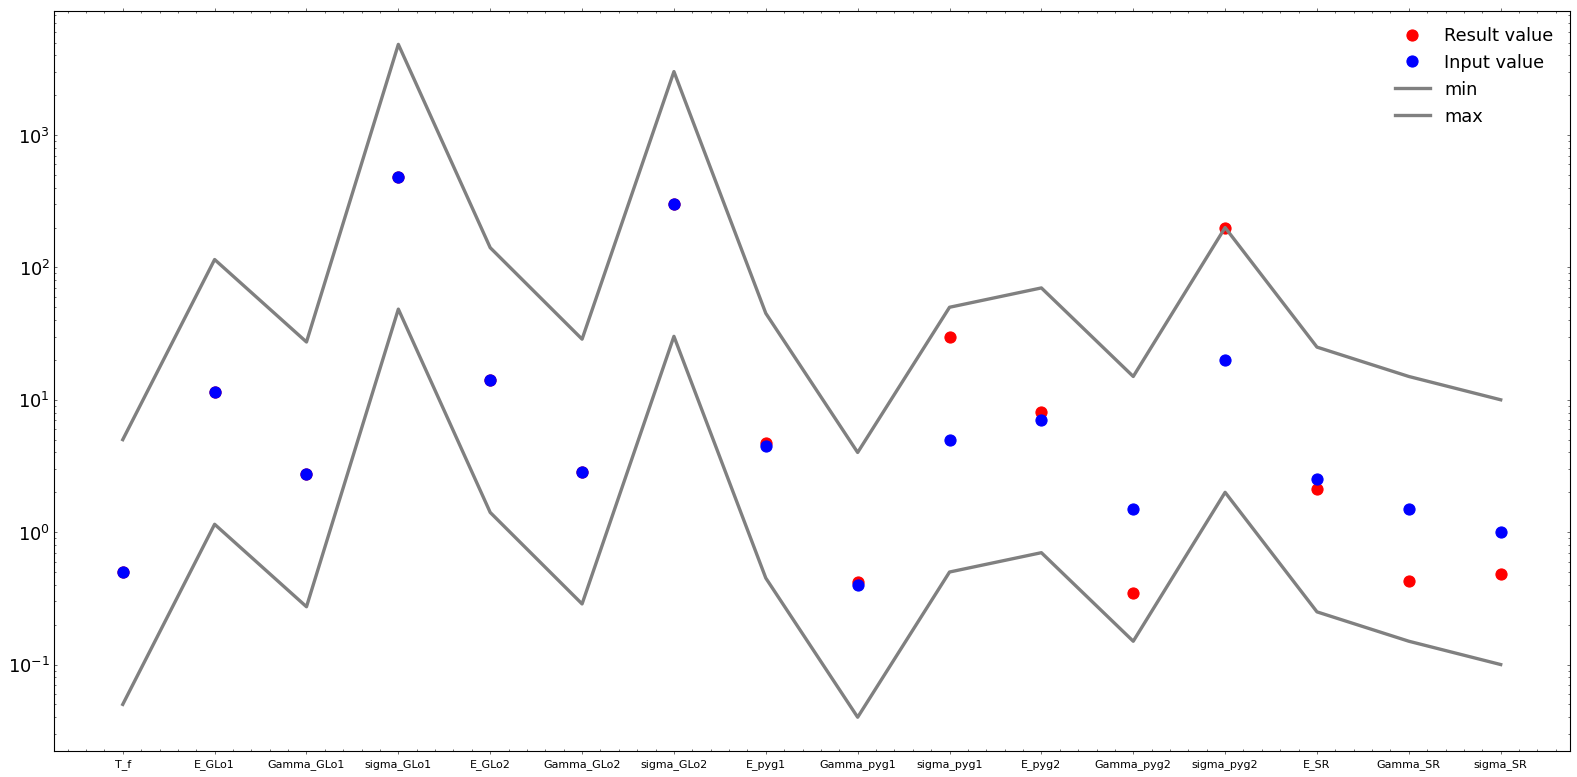

In [16]:
debug_mode=1
if debug_mode:
    """ This plots out the initial guess and optimised parameters and their min/max limits for the fit.
    This is meant to """
    fig, ax = plt.subplots(figsize=(20,10))
    
    D = params.valuesdict()
    X = range(len(D))
    R = results.params.valuesdict()
    ax.plot(X, list(R.values()), 'ro', label='Result value')
    ax.plot(X, list(D.values()), 'bo', label='Input value')
    
    ax.plot(X, minimum, color="grey", label="min")
    ax.plot(X, maximum, color="grey", label="max")

    
    ax.set_xticks(X)
    ax.tick_params(axis='x', which='major', labelsize=10, direction='out')
    ax.set_xticklabels(list(R.keys()))
    
    ax.set_yscale("log")
    ax.legend()
    fig.show()